# Challenge: Feedback analysis

We've mentioned that Naive Bayes is particularly good for text classification problems. Before we made a spam filter. Now we'll perform a sentiment analysis, classifying whether feedback left on a website is either positive or negative.

Again the UCI Machine Learning database has a nice labeled [dataset of sentiment labelled sentences](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) for us to use. This dataset was created for the paper [From Group to Individual Labels using Deep Features](http://mdenil.com/media/papers/2015-deep-multi-instance-learning.pdf), Kotzias et. al., KDD 2015.

Pick one of the company data files and build your own classifier. When you're satisfied with its performance (at this point just using the accuracy measure shown in the example), test it on one of the other datasets to see how well these kinds of classifiers translate from one context to another.

Include your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn as sk
%matplotlib inline

## Amazon Feedback

I choose the dataset of Amazon, and import it as dataframe.

In [2]:
data_path = './data/sentiment labelled sentences/amazon_cells_labelled.txt'
df_orig = pd.read_csv(data_path, delimiter='\t', header=None)
df_orig.columns = ['text','positive']

In [3]:
df_orig.head()

,text,positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
print('Shape of the dataframe: ', df_orig.shape)
print('Num. of positive samples: ' , sum(df_orig.positive))

Shape of the dataframe:  (1000, 2)
Num. of positive samples:  500


In [5]:
# Print the positive cases
df_orig.loc[df_orig.positive==1]

,text,positive
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
4,The mic is great.,1
7,If you are Razr owner...you must have this!,1
10,And the sound quality is great.,1
11,He was very impressed when going from the orig...,1
13,Very good quality though,1
15,Highly recommend for any one who has a blue to...,1
17,So Far So Good!.,1
18,Works great!.,1


To make the sentence clear, I make them all lowercase and get rid of special characters except Roman alphabet & space & apostrophe(').

In [6]:
# Keep the original dataset and only modify the copied one.
df = df_orig.copy()

In [7]:
import re  # regular expression

def featuring_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^A-Za-z' ]", '', sentence)
    return sentence
    

df.text = df_orig.text.apply(lambda x: featuring_text(x))

I build my own kewords for positive comments and add the new features to the dataframe

In [8]:
keywords = ['good', 'fine', 'great', 'nice', 'easy', 'beautiful', 'impressed', 'love', 'like']

In [9]:
for key in keywords:
    df[str(key)] = df.text.str.contains(str(key), case=False)

In [10]:
df.head()

,text,positive,good,fine,great,nice,easy,beautiful,impressed,love,like
0,so there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,False
1,good case excellent value,1,True,False,False,False,False,False,False,False,False
2,great for the jawbone,1,False,False,True,False,False,False,False,False,False
3,tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,False
4,the mic is great,1,False,False,True,False,False,False,False,False,False


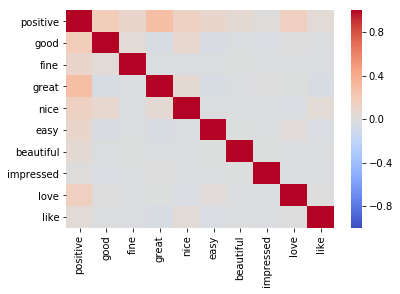

In [11]:
sns.heatmap(df.corr(), cmap='coolwarm',  vmin = -1.0, vmax = 1.0)
plt.show()

In [12]:
data = df[keywords]
target = df['positive']

In [13]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

def train_and_predict(data, target):
    # Naive Bayesian - Bernoulli classifer
    clf = BernoulliNB()
    # Fitting
    clf.fit(X=data, y=target)
    # Predicting: classification 
    y_pred = clf.predict(data)
    
    return y_pred

y_pred = train_and_predict(data, target)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
print("Accuracy: ", (target == y_pred).sum()/data.shape[0])    

Number of mislabeled points out of a total 1000 points : 313
Accuracy:  0.687


In this result, we can see that the accuracy is not satisfied. Becuase, I choose the keywords just by my intuition. Let's add more features and update the keyword.

First, we can count the number of word in the text.

In [14]:
df['words'] = df.text.apply(lambda x: len(x.split()))
df[['positive', 'words']].head(20)

,positive,words
0,0,21
1,1,4
2,1,4
3,0,10
4,1,4
5,0,17
6,0,21
7,1,8
8,0,7
9,0,7


Compare the histograms of the number of words in the two groups.

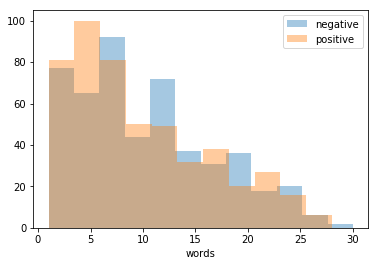

In [15]:
sns.distplot(df.loc[df.positive==0].words, kde=False)
sns.distplot(df.loc[df.positive==1].words, kde=False)
plt.legend(['negative', 'positive'])
plt.show()

Hmmm, there is not huge difference between the two. Let's check the frequencies of word.

In [16]:
def freq_words(data):
    # Utilize dictionary: O(1) complexity
    freq_word_list = {}
    strings_dataframe = data.apply(lambda x: x.split())
    for strings in strings_dataframe:
        for string in strings:
            if string in freq_word_list:
                freq_word_list[str(string)] += 1
            else:
                freq_word_list[str(string)] = 1
    result = pd.DataFrame.from_dict(freq_word_list, orient='index')
    result.columns = ['count']
    return result

freq_word_pos = freq_words(df.loc[df.positive==1].text).sort_values('count', ascending=False)
freq_word_neg = freq_words(df.loc[df.positive==0].text).sort_values('count', ascending=False)

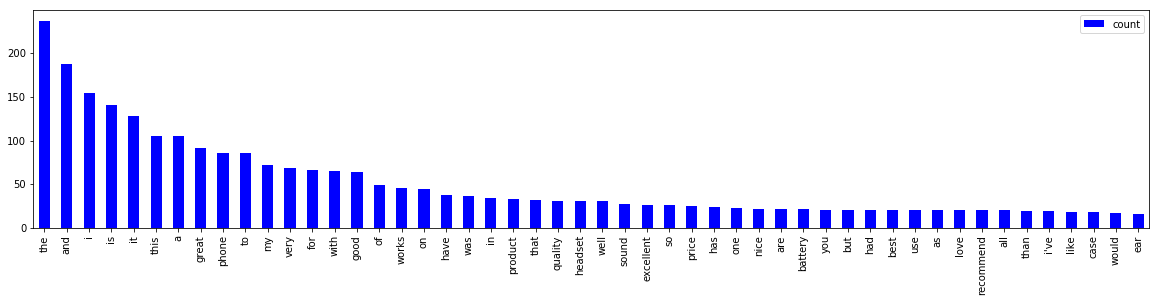

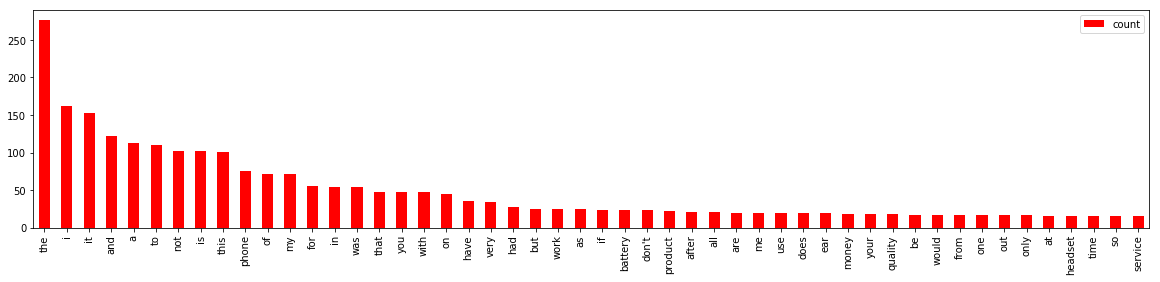

In [37]:
fig, axs = plt.subplots(figsize=(20,4))
freq_word_pos[:50].plot(kind='bar', ax=axs, color='b')
plt.show()

fig, axs = plt.subplots(figsize=(20,4))
freq_word_neg[:50].plot(kind='bar', ax=axs, color='r')
plt.show()

Finally, we got top 50 words in positive/negative words. So, I decide to pick up the representive words from each group and neglect the duplicated ones as new keywords.

In [38]:
freq_word_sum = freq_word_pos[:50].append(freq_word_neg[:50])
freq_word_sum

,count
the,237
and,188
i,154
is,141
it,128
this,105
a,105
great,92
phone,86
to,86


In [146]:
freq_word_sum_count = freq_word_sum.groupby(level=0).count()
freq_word_sum_count.columns = ['test']
keywords_new = list(freq_word_sum_count[freq_word_sum_count.test == 1].index)

In [158]:
keywords_new

['after',
 'at',
 'be',
 'best',
 'case',
 'does',
 "don't",
 'excellent',
 'from',
 'good',
 'great',
 'has',
 "i've",
 'if',
 'like',
 'love',
 'me',
 'money',
 'nice',
 'not',
 'only',
 'out',
 'price',
 'recommend',
 'service',
 'sound',
 'than',
 'time',
 'well',
 'work',
 'works',
 'your']

With the 'keywords_new', I train the classifier and get the better result, 76.6% accuracy!!

In [149]:
df = df_orig.copy()

In [150]:
for key in keywords_new:
    df[str(key)] = df.text.str.contains(str(key), case=False)

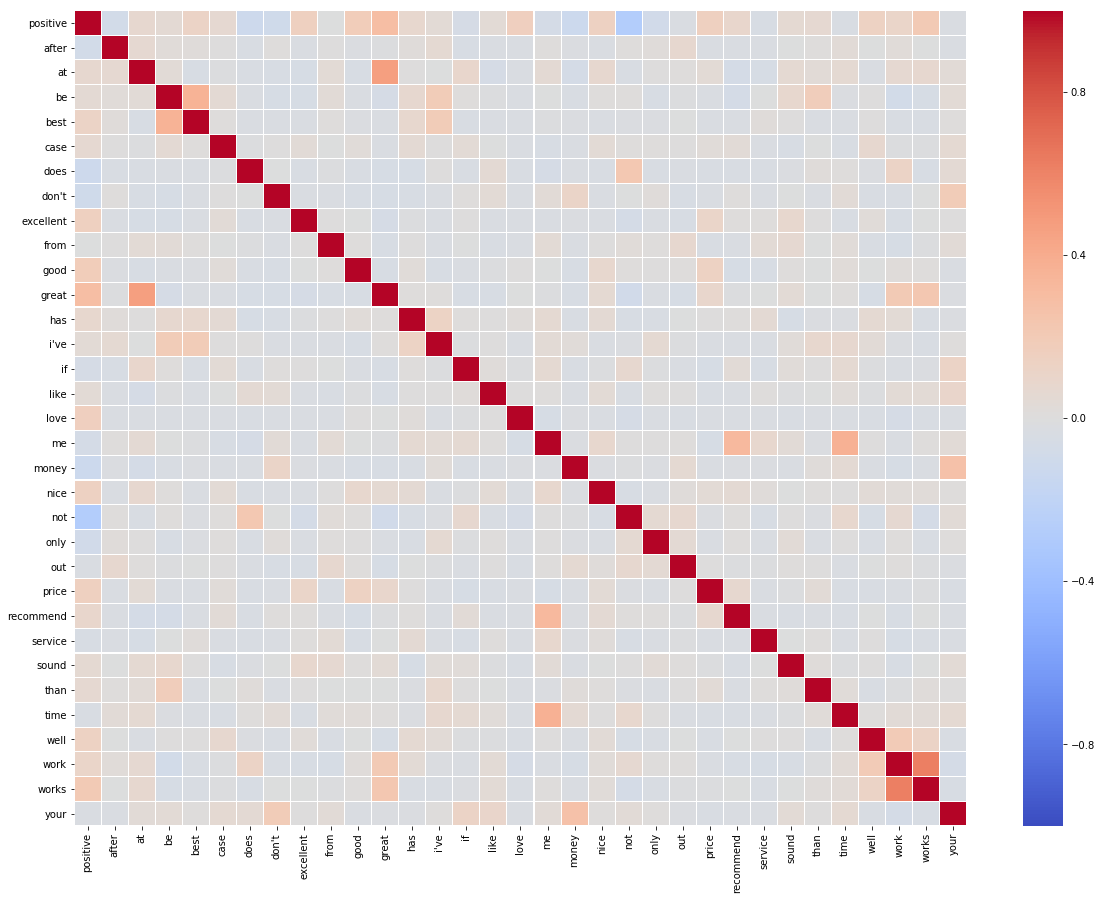

In [157]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap='coolwarm',  vmin = -1.0, vmax = 1.0, linewidths = 0.1)
plt.show()

In [152]:
sort_corr_cols = list(df.corr()['positive'].sort_values(ascending=False).index)

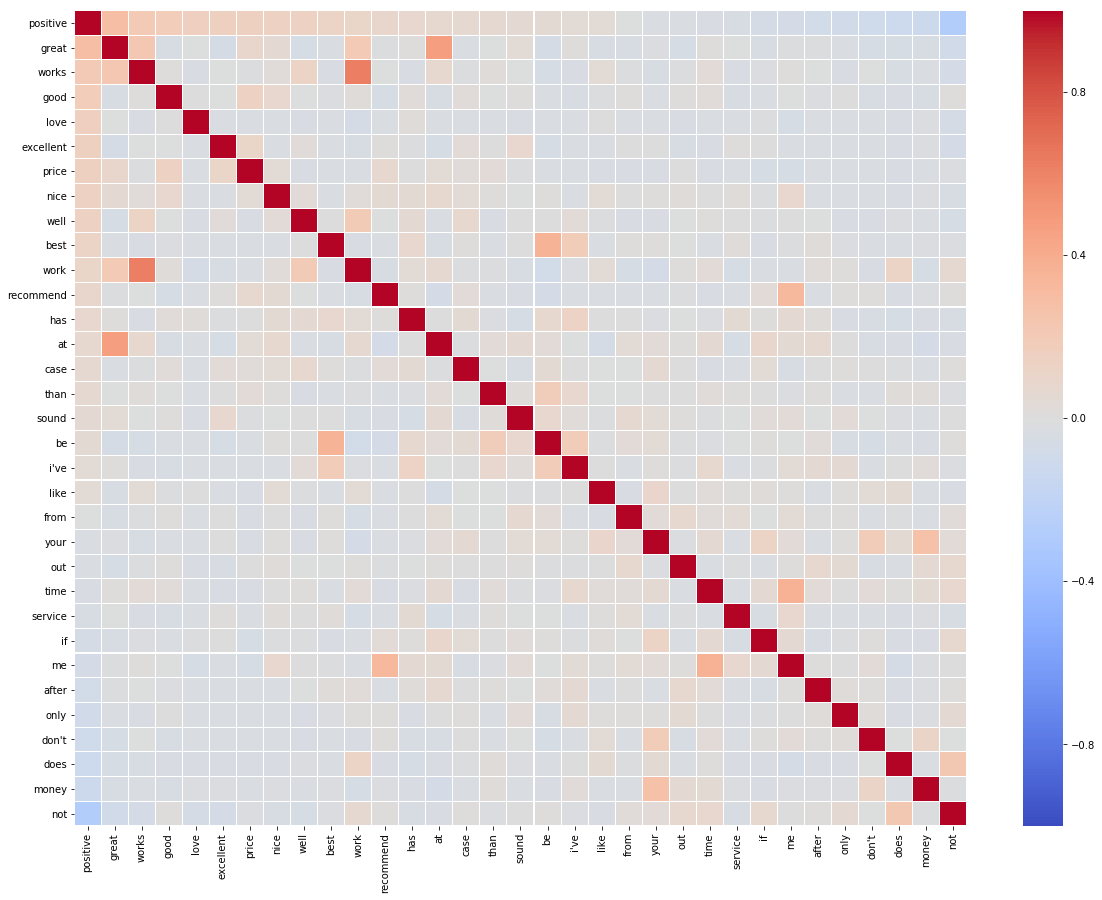

In [153]:
plt.subplots(figsize=(20,15))
sns.heatmap(df[sort_corr_cols].corr(), cmap='coolwarm',  vmin = -1.0, vmax = 1.0, linewidths = 0.1)
plt.show()

In [154]:
data = df[keywords_new]
target = df['positive']

In [155]:
y_pred = train_and_predict(data, target)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
print("Accuracy: ", (target == y_pred).sum()/data.shape[0]) 

Number of mislabeled points out of a total 1000 points : 234
Accuracy:  0.766
